In [110]:
%matplotlib inline
import numpy as np
import pandas as pd
import re
import os
import pdb
import matplotlib.pyplot as plt
import matplotlib
import seaborn
from collections import Counter


In [3]:
chat = pd.read_csv('data/transcripts/SBC001.trn',header=None)
chat.head()

,0,1
0,0.00 9.21\tLENORE: \t... So you don't need to ...,NaN
1,9.21 9.52\t \tto --,NaN
2,9.52 14.10\t \t... to do the feet?,NaN
3,14.10 15.78\t \t... [Do the hooves]?,NaN
4,15.01 16.78\tLYNNE: \t [(H)=] <YWN Well,NaN


In [43]:
file_path = 'data/transcripts/SBC018.trn'
print file_path
chat = []
with open(file_path) as f:
    for line in f:
        chat.append(line.strip())
chat[:5]

data/transcripts/SBC018.trn


['0.250\t1.045\tMARCIA:\tThey might not actually be,',
 '1.045\t1.335\t\t... be um,',
 '1.335\t2.290\t\t... back in the barn- --',
 '1.540\t3.000\t\t<X or [from X> the barn yet].',
 '2.325\t2.715\tLINDSEY:\t      [(TSK) Good morning,']

In [53]:
file_path = 'data/transcripts/SBC014.trn'
print file_path
chat = []
with open(file_path) as f:
    for line in f:        
        current_line = line.strip().split('\t')
        current_line[0] = current_line[0].split(' ')
        current_line[0]= '\t'.join(current_line[0][:3])
        current_line = '\t'.join(current_line)
        chat.append(current_line+'\n')

file_path = 'data/transcripts/prueba.trn'
with open(file_path,'w') as f:
    for line in chat:
        f.write(line)

data/transcripts/SBC014.trn


In [46]:
file_path[21:23]

'18'

In [118]:
def process_chat(file_path):
    #print file_path
    chat = []
    with open(file_path) as f:
        for line in f:
            chat.append(line.strip().split('\t'))

    if int(file_path[21:23])<14:
        chat[:] = [line for line in chat if len(line)==3] #delete comments
        # separate end and start times
        for i,line in enumerate(chat):
            chat[i] = chat[i][0].split() + line[1:] 
            m = re.search(':',chat[i][2])
            if m:
                chat[i][2] = chat[i][2][:m.start()]
            else:
                chat[i][2] = chat[i-1][2]
    else:
        chat[:] = [line for line in chat if len(line)==4]
    
    chat = pd.DataFrame(chat)
    chat.columns = ['start_time','end_time','person','speech']
    
    # clean speech
    chat['clean_speech'] = chat.speech #placeholder
    for i,text in enumerate(chat.clean_speech):
        text = re.sub(r'\[.*\]', '', text)
        text = re.sub(r'\(.*\)', '', text)
        text = re.sub(r'=','',text)
        text = re.sub(r'[^A-Za-z\']',' ',text)
        text = text.lower()
        chat.clean_speech[i] = text.split()
    return chat

In [117]:
'wWERE'.lower()

'wwere'

In [48]:
def get_list_of_words(clean_speech_series):
    """get list of words from time series of clean speech"""    
    words = []
    for text in clean_speech_series:
        words = words + text
    return words

In [119]:
#create a dictionary with all the words
chat1 = process_chat('data/transcripts/SBC001.trn')
words = get_list_of_words(chat1.clean_speech)
word_dict = Counter(words)

file_names = os.listdir('data/transcripts')
for file_name in file_names[1:] :
    chat = process_chat('data/transcripts/'+file_name)
    word_dict.update(get_list_of_words(chat.clean_speech))

In [124]:
mc_words = []
mc_counts = []
for word_count in word_dict.most_common(150):
    mc_words.append(word_count[0])
    mc_counts.append(word_count[1])

([<matplotlib.axis.YTick at 0x1ae5c2890>,
 <a list of 100 Text yticklabel objects>)

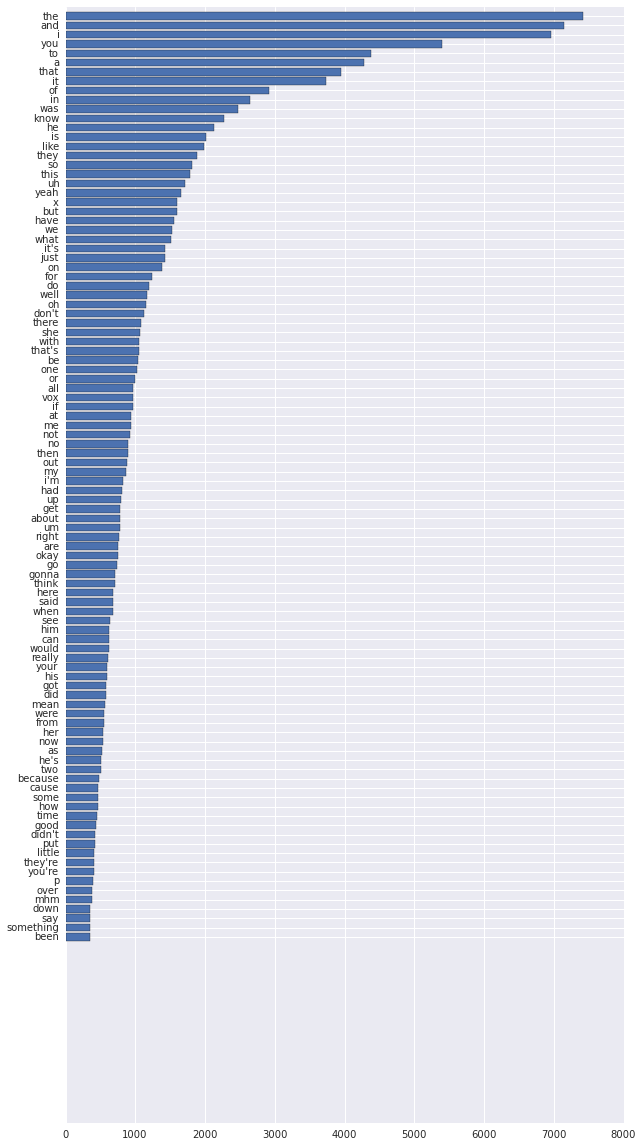

In [123]:
X = np.arange(len(mc_words))
h_bar = plt.barh(X, mc_counts[-1::-1], align='center')
plt.rcParams["figure.figsize"] = [20,5]
plt.yticks(X, mc_words[-1::-1])


In [67]:
word_dict.values()[:10]

[1, 2, 14, 2, 184, 1, 3, 4, 1, 9]